In [1]:
import os
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import nltk
# from wordcloud import WordCloud
from nrclex import NRCLex

sns.set(style='darkgrid')

# Daily Post Frequency

Note: DataFrame is NOT already sorted by date!

In [2]:
#change this to be whatever subreddit you want to analyze
subreddit = 'MentalHealth'

In [3]:
df = pd.read_csv(f'{subreddit}_data/raw_data_2017/01Jan2017.csv').drop(['Unnamed: 0'], axis=1)
for year in range(2017, 2021):
    for file in os.listdir(f'{subreddit}_data/raw_data_{year}'):
        if file[-3:] == 'csv':
            df_new = pd.read_csv(f'{subreddit}_data/raw_data_{year}/{file}').drop(['Unnamed: 0'], axis=1)
            df_new.time = df_new.time.apply(lambda x: file[:-4])
            df = pd.concat([df, df_new]).reset_index(drop=True)
df.head()

,text,time,score
0,"I don't know how many of you read it, but a fe...",01Jan2017,6
1,The reason that it occurred to me that I may h...,01Jan2017,1
2,Sometimes I don't really feel like a participa...,01Jan2017,5
3,"Hi, and thanks for reading this post. I'm look...",01Jan2017,1
4,"Loaded question I know, trying to scribble thi...",01Jan2017,7


In [4]:
# reformat dates
df.time = df.time.apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [5]:
# sort by date
df = df.sort_values('time')

In [6]:
# calculate frequencies for each date
sorted_dates = df.time.value_counts().sort_index()

freq = pd.DataFrame(sorted_dates).reset_index().rename(columns={'time': 'num_posts', 'index': 'date'})

# calculate SMOOTHED frequencies 
smoothed_freq = pd.DataFrame(sorted_dates).rolling(30).mean().reset_index().rename(columns={'time': 'num_posts',
                                                                                            'index': 'date'})

In [7]:
series = alt.Chart(freq).mark_line(opacity=0.3,
                                  ).encode(x='date', y='num_posts'
                                  ).properties(title=f'Frequency of r/{subreddit} Posts'
                                  ).interactive(bind_y=False)

smoothed = alt.Chart(smoothed_freq.reset_index()).mark_line(
                                                           ).encode(x='date', y='num_posts', tooltip=['date', 'num_posts']
                                                           ).properties(title=f'Frequency of r/{subreddit} Posts'
                                                           ).interactive(bind_y=False)

chart = (series + smoothed).properties(width=800, height=300)
chart.save(f'figures/{subreddit}/post_freq.html')

### Normalized by Subscribers 

In [8]:
trend = pd.read_csv(f'{subreddit}_data/subscriber_count.csv')
trend['subscribers'] = trend['subscribers'].interpolate()
trend['date'] = trend['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M').replace(hour=0, minute=0))

overlap = pd.DataFrame()
dates = freq[freq['date'].isin(trend.date)]['date']
overlap['date'] = dates
overlap_subs = trend[trend['date'].isin(dates)].reset_index().drop(['index'], axis=1)

overlap['detrended'] = freq['num_posts'] / overlap_subs['subscribers']

In [9]:
series = alt.Chart(overlap).mark_line(opacity=0.3,
                                  ).encode(x='date:T', y='detrended:Q'
                                  ).properties(title=f'Frequency of r/{subreddit} Posts, Normalized by Subscribers'
                                  ).interactive(bind_y=False)
series

overlap['smoothed'] = overlap['detrended'].rolling(30).mean()
smoothed = alt.Chart(overlap).mark_line(
                                         ).encode(x='date:T', y='smoothed:Q', tooltip=['date', 'smoothed']
                                         ).properties(title=f'Frequency of r/{subreddit} Posts, Normalized by Subscribers'
                                         ).interactive(bind_y=False)


chart = (series + smoothed).properties(width=800, height=300)
chart.save(f'figures/{subreddit}/post_freq_normalized.html')

# Scores

In [10]:
scores = df[['time', 'score']]
scores['score'] = scores['score'].apply(lambda x: np.log(x + 1))
groups = scores.groupby([scores.time.dt.year, scores.time.dt.month])

all_scores = pd.DataFrame(columns=['time', 'score'])
for i, group in enumerate(groups):
    if i == 0:
        continue
    all_scores = all_scores.append(group[1])
all_scores

/Users/jberman/anaconda3/envs/EECS_Affective/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,time,score
4274,2017-02-02,1.098612
4277,2017-02-02,0.693147
4266,2017-02-02,0.693147
4265,2017-02-02,1.791759
4276,2017-02-02,0.693147
...,...,...
73100,2020-12-30,0.693147
73101,2020-12-30,0.693147
73102,2020-12-30,0.693147
73104,2020-12-30,0.693147


## By Month

In [11]:
def clean_time(x):
    x = datetime.strftime(x, '%Y-%m')
    return (int(x[:4]) - 2017) * 12 + int(x[5:7])

In [12]:
scores = df[['time', 'score']]
scores['score'] = scores['score'].apply(lambda x: np.log(x + 1))
groups = scores.groupby([scores.time.dt.year, scores.time.dt.month])

all_scores = pd.DataFrame(columns=['time', 'score'])
for i, group in enumerate(groups):
    if i == 0:
        continue
    all_scores = all_scores.append(group[1])
all_scores['time'] = all_scores['time'].apply(clean_time)
all_scores

/Users/jberman/anaconda3/envs/EECS_Affective/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,time,score
4274,2,1.098612
4277,2,0.693147
4266,2,0.693147
4265,2,1.791759
4276,2,0.693147
...,...,...
73100,48,0.693147
73101,48,0.693147
73102,48,0.693147
73104,48,0.693147


In [13]:
slider = alt.binding_range(name='date: ', min=1, 
                                          max=48,
                                          step=1)

select_year = alt.selection_single(name='date', fields=['time'],
                                   bind=slider, init={'time': 1})

scores_chart = alt.Chart(all_scores).add_selection(
    select_year
).transform_filter(
    select_year
).properties(
    width=700, height=300
).encode(
    x=alt.X('score:Q', bin=alt.Bin(extent=[0, 6], step=0.25)),
    y=alt.Y('count()')
).mark_bar().properties(title=f'Log-Score Distribution (r/{subreddit})')

scores_chart.save(f'figures/{subreddit}/score_dist.html')

## By Year

In [14]:
def clean_time_year(x):
    x = datetime.strftime(x, '%Y-%m')
    return int(x[:4])

In [15]:
scores = df[['time', 'score']]
scores['score'] = scores['score'].apply(lambda x: np.log(x + 1))
groups = scores.groupby([scores.time.dt.year])

all_scores = pd.DataFrame(columns=['time', 'score'])
for i, group in enumerate(groups):
    if i == 0:
        continue
    all_scores = all_scores.append(group[1])
all_scores['time'] = all_scores['time'].apply(clean_time_year)
all_scores

/Users/jberman/anaconda3/envs/EECS_Affective/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,time,score
14784,2018,0.000000
14783,2018,0.693147
14782,2018,0.693147
14781,2018,1.945910
14780,2018,2.197225
...,...,...
73100,2020,0.693147
73101,2020,0.693147
73102,2020,0.693147
73104,2020,0.693147


In [16]:
slider = alt.binding_range(name='date: ', min=2017, 
                                          max=2020,
                                          step=1)

select_year = alt.selection_single(name='date', fields=['time'],
                                   bind=slider, init={'time': 2017})

scores_chart = alt.Chart(all_scores).add_selection(
    select_year
).transform_filter(
    select_year
).properties(
    width=700, height=300
).encode(
    x=alt.X('score:Q', bin=alt.Bin(extent=[0, 6], step=0.25)),
    y=alt.Y('count()', scale=alt.Scale(type='log'))
).mark_bar().properties(title=f'Log-Score Distribution (r/{subreddit})')

scores_chart.save(f'figures/{subreddit}/score_dist_year.html')

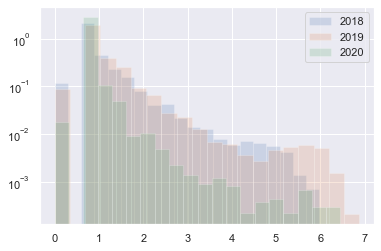

In [17]:
for i, group in enumerate(groups):
    if i == 0: 
        continue
    plt.hist(group[1]['score'], alpha=0.2, density=True, bins=20, label=group[0])
    plt.yscale('log')
    plt.legend()

# Emotion Content
as measured by NRCLex.

**ONLY RUN THESE CELLS ONCE ============================================================================================**

In [18]:
#more EDA using emotion data package NRCLex
#question: should i standardize each post by number of tokens and then standardize whole weeks count by number of posts?
features = {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5,
            'surprise': 6, 'trust': 7, 'negative': 8, 'positive': 9}

dates = sorted([datetime.strftime(datetime.strptime(file[:-4], '%d%b%Y'), '%Y-%m-%d') \
                for year in range(2017, 2021) \
                for file in os.listdir(f'{subreddit}_data/raw_data_{year}') \
                if file[-3:] == 'csv'])

In [19]:
data = []
df_text = df[df['text'] != '[deleted]']

for date in dates:
    data.append(df_text[df_text['time'] == datetime.strptime(date, '%Y-%m-%d')])

In [20]:
emotion_by_day = np.zeros((len(data), 10))
for i in tqdm(range(0, len(data))):
    texts = data[i]['text'].values
    num_tokens_per_day = 0
    for j in texts:
        try:
            tokens = nltk.word_tokenize(j.lower())
            num_tokens_per_day += len(tokens)
            emotion = NRCLex(j.lower())
            emotion_dict = emotion.raw_emotion_scores
            for key in emotion_dict:
                col = features[key]
                count = emotion_dict[key]
                emotion_by_day[i, col] += count
        except:
            # skip over non-text posts
            continue
        
    #normalize frequency of each emotion (over the 1 week period) by number of tokens (over the 1 week period)
    emotion_by_day[i, :] = (emotion_by_day[i, :] / num_tokens_per_day) * 100
            
emotion_scores = pd.DataFrame(emotion_by_day, 
                              columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                                         'sadness', 'surprise', 'trust', 'negative', 'positive'], 
                              index = dates)
emotion_scores.head()

100%|██████████| 732/732 [09:15<00:00,  1.32it/s]


,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
2017-01-01,1.835547,2.238472,1.193852,2.313088,1.417699,2.208626,0.910312,2.029548,3.790479,3.521862
2017-01-03,1.708907,1.940623,1.071687,2.389573,1.332368,2.548878,0.897900,2.013034,4.069515,3.128168
2017-01-05,1.576069,2.315857,0.852364,1.913799,1.350917,2.058540,0.723705,2.315857,3.634609,3.216468
2017-01-07,1.590584,2.210911,1.081597,1.972324,1.845077,2.067759,0.970256,2.767616,3.562908,3.547002
2017-01-09,1.463148,1.613565,0.861480,1.750308,0.820457,1.627239,0.574320,1.818679,2.994667,2.693833


In [21]:
# make sure date is in the right format
emotion_scores_new = emotion_scores.reset_index().rename({'index': 'date'}, axis=1)
emotion_scores_new.date = emotion_scores_new.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
emotion_scores_new.to_json(f'clean_data/{subreddit}/emotion_scores.json')

**=======================================================================================================================**

In [22]:
# compute rolling mean to reduce noise
emotion_scores = pd.read_json(f'clean_data/{subreddit}/emotion_scores.json')
emotion_scores = pd.concat([emotion_scores.date, emotion_scores.rolling(7).mean()], axis=1).rename({0: 'date'}, axis=1)
emotion_scores = emotion_scores.melt('date', var_name='emotion', value_name='score')
# melt emotions for easier plotting if read in wide form
emotion_scores.to_json(f'clean_data/{subreddit}/emotion_scores_long.json')

In [23]:
emotion_scores = pd.read_json(f'clean_data/{subreddit}/emotion_scores_long.json')
emotion_scores.date

0      2017-01-01
1      2017-01-03
2      2017-01-05
3      2017-01-07
4      2017-01-09
          ...    
7315   2020-12-22
7316   2020-12-24
7317   2020-12-26
7318   2020-12-28
7319   2020-12-30
Name: date, Length: 7320, dtype: datetime64[ns]

In [24]:
alt.data_transformers.enable('json')

selection = alt.selection_multi(fields=['emotion'], bind='legend')
series = alt.Chart(emotion_scores).mark_line(
                                  ).encode(x='date:T', y='score:Q', color='emotion:N',
                                           opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
                                           tooltip=['score']
                                  ).properties(title=f'Average Emotional Tokens per Post (r/{subreddit})', width=800, height=300
                                  ).add_selection(selection
                                  ).interactive(bind_y=False)

alt.data_transformers.enable('default')
series.save(f'figures/{subreddit}/emotion_freq.html')

In [25]:
# # generating word clouds for each of the weeks
# for i in range(0,24):
#     titles = data[i]['title']
#     texts = data[i]['text']
#     list_of_words = ''
#     for j in titles:
#         tokens = nltk.word_tokenize(j.lower())
#         list_of_words += " ".join(tokens)+" "
#     for k in texts:
#         tokens = nltk.word_tokenize(k.lower())
#         list_of_words += " ".join(tokens)+" "
#     wc = WordCloud().generate(list_of_words)   
#     plt.imshow(wc)
#     plt.show()